In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('punkt')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import tokenize

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown, display, clear_output

import pickle
import json
from textblob import TextBlob
import nltk
from scipy import spatial
import torch
import spacy

import _pickle as cPickle
from pathlib import Path

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def dumpPickle(fileName, content):
    pickleFile = open(fileName, 'wb')
    cPickle.dump(content, pickleFile, -1)
    pickleFile.close()

def loadPickle(fileName):    
    file = open(fileName, 'rb')
    content = cPickle.load(file)
    file.close()
    
    return content
    
def pickleExists(fileName):
    file = Path(fileName)
    
    if file.is_file():
        return True
    
    return False

In [ ]:
#reading data
wordPickleName = '/content/drive/My Drive/Capstone Project/Data/pickles/wordsDf.pkl' #rohit
# wordPickleName = '/content/drive/My Drive/Data/pickles/wordsDf.pkl'  #everyone wlse
df = loadPickle(wordPickleName)
df.head()

,text,isAnswer,titleId,paragrapghId,sentenceId,wordCount,NER,POS,TAG,DEP,shape
0,Architecturally,False,0,0,0.0,1,None,ADV,RB,advmod,Xxxxx
1,school,False,0,0,0.0,1,None,NOUN,NN,nsubj,xxxx
2,Catholic,False,0,0,0.0,1,NORP,None,None,None,Xxxxx
3,character,False,0,0,0.0,1,None,NOUN,NN,dobj,xxxx
4,Atop,False,0,0,1.0,1,None,ADP,IN,prep,Xxxx


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127357 entries, 0 to 1127356
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   text          1127357 non-null  object 
 1   isAnswer      1127357 non-null  bool   
 2   titleId       1127357 non-null  int64  
 3   paragrapghId  1127357 non-null  int64  
 4   sentenceId    890717 non-null   float64
 5   wordCount     1127357 non-null  int64  
 6   NER           255574 non-null   object 
 7   POS           871783 non-null   object 
 8   TAG           871783 non-null   object 
 9   DEP           871783 non-null   object 
 10  shape         1127357 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 87.1+ MB


In [ ]:
# One-hot encoding
# We need to encode the categorical data - NER, POS, TAG, DEP, shape
columnsToEncode = ['NER', 'POS', "TAG", 'DEP']

In [ ]:
for column in columnsToEncode:
    print(column)
    one_hot = pd.get_dummies(df[column])
    one_hot = one_hot.add_prefix(column + '_')

    df = df.drop(column, axis = 1)
    df = df.join(one_hot)

NER
POS
TAG
DEP


In [ ]:
df.head()

,text,isAnswer,titleId,paragrapghId,sentenceId,wordCount,shape,NER_CARDINAL,NER_DATE,NER_EVENT,NER_FAC,NER_GPE,NER_LANGUAGE,NER_LAW,NER_LOC,NER_MONEY,NER_NORP,NER_ORDINAL,NER_ORG,NER_PERCENT,NER_PERSON,NER_PRODUCT,NER_QUANTITY,NER_TIME,NER_WORK_OF_ART,POS_ADJ,POS_ADP,POS_ADV,POS_CCONJ,POS_DET,POS_INTJ,POS_NOUN,POS_NUM,POS_PART,POS_PRON,POS_PROPN,POS_PUNCT,POS_SCONJ,POS_SYM,POS_VERB,...,DEP_acomp,DEP_advcl,DEP_advmod,DEP_agent,DEP_amod,DEP_appos,DEP_attr,DEP_aux,DEP_auxpass,DEP_cc,DEP_ccomp,DEP_compound,DEP_conj,DEP_csubj,DEP_csubjpass,DEP_dative,DEP_dep,DEP_det,DEP_dobj,DEP_intj,DEP_mark,DEP_meta,DEP_neg,DEP_nmod,DEP_npadvmod,DEP_nsubj,DEP_nsubjpass,DEP_nummod,DEP_oprd,DEP_parataxis,DEP_pcomp,DEP_pobj,DEP_poss,DEP_predet,DEP_prep,DEP_prt,DEP_punct,DEP_quantmod,DEP_relcl,DEP_xcomp
0,Architecturally,False,0,0,0.0,1,Xxxxx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,school,False,0,0,0.0,1,xxxx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Catholic,False,0,0,0.0,1,Xxxxx,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,character,False,0,0,0.0,1,xxxx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Atop,False,0,0,1.0,1,Xxxx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
columnsToDrop = ['text', 'titleId', 'paragrapghId', 'sentenceId', 'shape']
df = df.drop(columnsToDrop, axis = 1)
df.head()

,isAnswer,wordCount,NER_CARDINAL,NER_DATE,NER_EVENT,NER_FAC,NER_GPE,NER_LANGUAGE,NER_LAW,NER_LOC,NER_MONEY,NER_NORP,NER_ORDINAL,NER_ORG,NER_PERCENT,NER_PERSON,NER_PRODUCT,NER_QUANTITY,NER_TIME,NER_WORK_OF_ART,POS_ADJ,POS_ADP,POS_ADV,POS_CCONJ,POS_DET,POS_INTJ,POS_NOUN,POS_NUM,POS_PART,POS_PRON,POS_PROPN,POS_PUNCT,POS_SCONJ,POS_SYM,POS_VERB,POS_X,TAG_'',TAG_.,TAG_ADD,TAG_AFX,...,DEP_acomp,DEP_advcl,DEP_advmod,DEP_agent,DEP_amod,DEP_appos,DEP_attr,DEP_aux,DEP_auxpass,DEP_cc,DEP_ccomp,DEP_compound,DEP_conj,DEP_csubj,DEP_csubjpass,DEP_dative,DEP_dep,DEP_det,DEP_dobj,DEP_intj,DEP_mark,DEP_meta,DEP_neg,DEP_nmod,DEP_npadvmod,DEP_nsubj,DEP_nsubjpass,DEP_nummod,DEP_oprd,DEP_parataxis,DEP_pcomp,DEP_pobj,DEP_poss,DEP_predet,DEP_prep,DEP_prt,DEP_punct,DEP_quantmod,DEP_relcl,DEP_xcomp
0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,False,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
df.isnull().sum().sum()

0

In [ ]:
#train test split
from sklearn.model_selection import train_test_split

x_data = df.drop(labels=['isAnswer'], axis=1)
y_data = df['isAnswer']

x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size=0.25, 
                                                    random_state=4)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(845517, 116)
(845517,)
(281840, 116)
(281840,)


Model Building

Base Model

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split

from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score,cohen_kappa_score

In [ ]:
def plot_roc(ytrue,ypred):
  fpr,tpr,th=metrics.roc_curve(ytrue,ypred[:,1])
  fig,ax=plt.subplots()
  plt.plot(fpr,tpr)
  plt.plot(fpr,fpr)
  plt.xlabel('alpha')
  plt.ylabel('1-beta')
  ax1=ax.twinx()
  plt.show()

In [ ]:
def modelscores(ytrue,ypred,ypred_proba):
  print("Confusion matrix score: \n",confusion_matrix(ytrue,ypred))
  print("\nClassification report score: \n",classification_report(ytrue,ypred))
  print("\nROC_AUC score:",round(roc_auc_score(ytrue,ypred_proba[:,1]),2))
  print("\nAccuracy score:",round(accuracy_score(ytrue,ypred),2))
  print("\nCohen Kappa score:",round(cohen_kappa_score(ytrue,ypred),2))

In [ ]:
#Logistic regression
lr = LogisticRegression()

predictor_lr = lr.fit(x_train, y_train)
y_pred_lr = predictor_lr.predict(x_test)
y_pred_proba_lr = predictor_lr.predict_proba(x_test)

In [ ]:
modelscores(y_test, y_pred_lr, y_pred_proba_lr)

Confusion matrix score: 
 [[274281      0]
 [  7559      0]]

Classification report score: 
               precision    recall  f1-score   support

       False       0.97      1.00      0.99    274281
        True       0.00      0.00      0.00      7559

    accuracy                           0.97    281840
   macro avg       0.49      0.50      0.49    281840
weighted avg       0.95      0.97      0.96    281840


ROC_AUC score: 0.83

Accuracy score: 0.97

Cohen Kappa score: 0.0


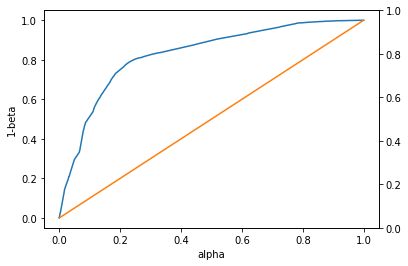

In [ ]:
plot_roc(y_test,y_pred_proba_lr)

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state = 0)
scores = cross_val_score(predictor_lr, x_data, y_data, cv = kf, scoring = 'roc_auc',n_jobs=-1)

print("Bias Error:",round(scores.mean(), 2))
print("Variance Error:",round(scores.std(ddof=1), 2))

Bias Error: 0.83
Variance Error: 0.0021965897277407332


**Inferences**
we are able to see the logistic regression model able to predict up to 82% accuracy, on checking the True Positive prediction in confusion matrix is 0.


In [ ]:
#Naive Bayes
gnb = GaussianNB()

predictor_nb = gnb.fit(x_train, y_train)
y_pred_nb = predictor_nb.predict(x_test)
y_pred_proba_nb = predictor_nb.predict_proba(x_test)

# correctCount = (y_test == y_pred_nb).sum()
# print('Correctly guessed:', '{:.2f}%'.format((correctCount / len(y_test)) * 100))
# print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_nb[:,1]))

In [ ]:
modelscores(y_test, y_pred_nb, y_pred_proba_nb)

Confusion matrix score: 
 [[ 57236 217045]
 [   130   7429]]

Classification report score: 
               precision    recall  f1-score   support

       False       1.00      0.21      0.35    274281
        True       0.03      0.98      0.06      7559

    accuracy                           0.23    281840
   macro avg       0.52      0.60      0.20    281840
weighted avg       0.97      0.23      0.34    281840


ROC_AUC score: 0.6

Accuracy score: 0.23

Cohen Kappa score: 0.01


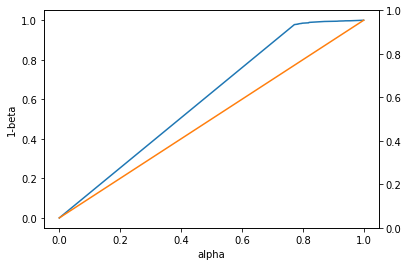

In [ ]:
plot_roc(y_test,y_pred_proba_nb)

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state = 0)
scores = cross_val_score(predictor_nb, x_data, y_data, cv = kf, scoring = 'roc_auc',n_jobs=-1)

print("Bias Error:",round(scores.mean(), 2))
print("Variance Error:",round(scores.std(ddof=1), 2))

Bias Error: 0.6
Variance Error: 0.0


**Inference**: We are able to see the Gaussian naïve bayes model able to predict up to 60% accuracy, on checking the confusion matrix , we are able to predict both TP and TN with error. 
When compared to Logistic regression, GB is performing better.

In [ ]:
#decision tree
dt = DecisionTreeClassifier()

predictor_dt = dt.fit(x_train, y_train)
y_pred_dt = predictor_dt.predict(x_test)
y_pred_proba_dt = predictor_dt.predict_proba(x_test)

# print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_dt[:,1]))

In [ ]:
modelscores(y_test, y_pred_dt, y_pred_proba_dt)

Confusion matrix score: 
 [[274279      2]
 [  7559      0]]

Classification report score: 
               precision    recall  f1-score   support

       False       0.97      1.00      0.99    274281
        True       0.00      0.00      0.00      7559

    accuracy                           0.97    281840
   macro avg       0.49      0.50      0.49    281840
weighted avg       0.95      0.97      0.96    281840


ROC_AUC score: 0.83

Accuracy score: 0.97

Cohen Kappa score: -0.0


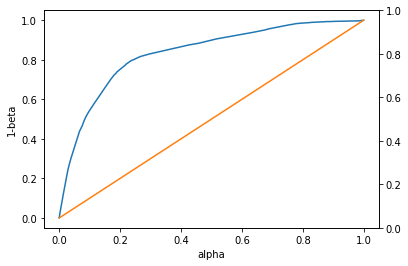

In [ ]:
plot_roc(y_test,y_pred_proba_dt)

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state = 0)
scores = cross_val_score(predictor_dt, x_data, y_data, cv = kf, scoring = 'roc_auc',n_jobs=-1)

print("Bias Error:",round(scores.mean(), 2))
print("Variance Error:",round(scores.std(ddof=1), 2))

Bias Error: 0.83
Variance Error: 0.0


**Inference**: we are able to see the Decision tree model able to predict up to 83% accuracy, on checking the confusion matrix, we are not able to predict single TP.

In [ ]:
#random forest
rf = RandomForestClassifier()

predictor_rf = rf.fit(x_train, y_train)
y_pred_rf = predictor_rf.predict(x_test)
y_pred_proba_rf = predictor_rf.predict_proba(x_test)

# print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_rf[:,1]))

In [ ]:
modelscores(y_test, y_pred_rf, y_pred_proba_rf)

Confusion matrix score: 
 [[274279      2]
 [  7559      0]]

Classification report score: 
               precision    recall  f1-score   support

       False       0.97      1.00      0.99    274281
        True       0.00      0.00      0.00      7559

    accuracy                           0.97    281840
   macro avg       0.49      0.50      0.49    281840
weighted avg       0.95      0.97      0.96    281840


ROC_AUC score: 0.83

Accuracy score: 0.97

Cohen Kappa score: -0.0


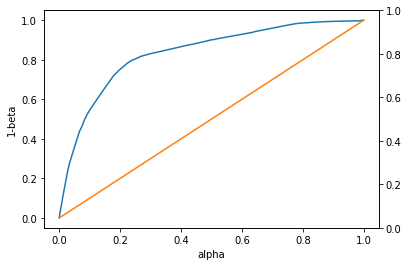

In [ ]:
plot_roc(y_test,y_pred_proba_rf)

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state = 0)
scores = cross_val_score(predictor_rf, x_data, y_data, cv = kf, scoring = 'roc_auc',n_jobs=-1)

print("Bias Error:",round(scores.mean(), 2))
print("Variance Error:",round(scores.std(ddof=1), 2))

Bias Error: 0.83
Variance Error: 0.0025243627820401276


**Inference**: We are able to see the Random Forest Classifier model able to predict up to 83% accuracy, on checking the confusion matrix, we are not able to predict single TP.

In [ ]:
# #SVM
# from sklearn import svm
# C = 1.0 # SVM regularization parameter
# predictor_svc = svm.SVC(kernel='linear', C=1,gamma='auto').fit(x_train, y_train)
# y_pred_svc = svc.predict(x_test)
# y_pred_proba_svc = predictor_svc.predict_proba(x_test)

# print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_svc[:,1]))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier

In [ ]:
#Naive Bayes
gnb = GaussianNB()
adaboost = AdaBoostClassifier(base_estimator=gnb)

predictor_adagb = adaboost.fit(x_train, y_train)
y_pred_adagb = predictor_adagb.predict(x_test)
y_pred_proba_adagb = predictor_adagb.predict_proba(x_test)

# correctCount = (y_test == y_pred_nb).sum()
# print('Correctly guessed:', '{:.2f}%'.format((correctCount / len(y_test)) * 100))
# print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_adagb[:,1]))

In [ ]:
gnb = GaussianNB()
for i in range(1,25):
  adaboost = AdaBoostClassifier(base_estimator=gnb,n_estimators=i)
  predictor_adagb = adaboost.fit(x_train, y_train)
  y_pred_adagb = predictor_adagb.predict(x_test)
  y_pred_proba_adagb = predictor_adagb.predict_proba(x_test)
  print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_adagb[:,1]))

AUC Test:  0.6047658659538686
AUC Test:  0.48814564433171154
AUC Test:  0.6546051764520116
AUC Test:  0.4192661023677237
AUC Test:  0.4245394510470717
AUC Test:  0.5021892148840982
AUC Test:  0.6864011422783642
AUC Test:  0.4272206113228597
AUC Test:  0.34821011773143196
AUC Test:  0.3467780303790282
AUC Test:  0.3613439841767555
AUC Test:  0.36133392576755774
AUC Test:  0.5040520253702521
AUC Test:  0.4868766480023271
AUC Test:  0.4867105460644034
AUC Test:  0.6082716013903235
AUC Test:  0.46996484446111125
AUC Test:  0.5553308254652579
AUC Test:  0.4672562022615071
AUC Test:  0.48451306629727037
AUC Test:  0.484544379329951
AUC Test:  0.45335898628973276
AUC Test:  0.5823199689849092
AUC Test:  0.518238136275768


In [ ]:
adaboost = AdaBoostClassifier(base_estimator=gnb,n_estimators=7)
predictor_adagb = adaboost.fit(x_train, y_train)
y_pred_adagb = predictor_adagb.predict(x_test)
y_pred_proba_adagb = predictor_adagb.predict_proba(x_test)
# print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_adagb[:,1]))

In [ ]:
modelscores(y_test, y_pred_adagb, y_pred_proba_adagb)

Confusion matrix score: 
 [[   879 273402]
 [     0   7559]]

Classification report score: 
               precision    recall  f1-score   support

       False       1.00      0.00      0.01    274281
        True       0.03      1.00      0.05      7559

    accuracy                           0.03    281840
   macro avg       0.51      0.50      0.03    281840
weighted avg       0.97      0.03      0.01    281840


ROC_AUC score: 0.69

Accuracy score: 0.03

Cohen Kappa score: 0.0


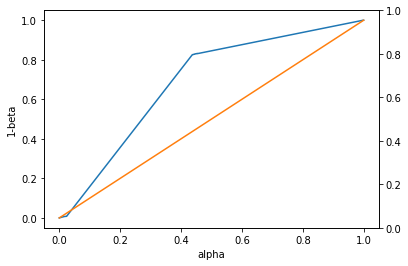

In [ ]:
plot_roc(y_test,y_pred_proba_adagb)

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state = 0)
scores = cross_val_score(adaboost, x_data, y_data, cv = kf, scoring = 'roc_auc',n_jobs=-1)
print("Bias Error:",round(scores.mean(), 2))
print("Variance Error:",round(scores.std(ddof=1),2))

Bias Error: 0.59
Variance Error: 0.13


In [ ]:
gnb = GaussianNB()
gnbag = BaggingClassifier(base_estimator=gnb)

predictor_gbbag = gnbag.fit(x_train, y_train)
y_pred_gbbag = predictor_gnbag.predict(x_test)
y_pred_proba_gbbag = predictor_gnbag.predict_proba(x_test)
# print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_gbbag[:,1]))

In [ ]:
modelscores(y_test, y_pred_gbbag, y_pred_proba_gbbag)

Confusion matrix score: 
 [[ 58231 216050]
 [   143   7416]]

Classification report score: 
               precision    recall  f1-score   support

       False       1.00      0.21      0.35    274281
        True       0.03      0.98      0.06      7559

    accuracy                           0.23    281840
   macro avg       0.52      0.60      0.21    281840
weighted avg       0.97      0.23      0.34    281840


ROC_AUC score: 0.61

Accuracy score: 0.23

Cohen Kappa score: 0.01


In [ ]:
gnb = GaussianNB()
for i in range(1,25):
  gnbag = BaggingClassifier(base_estimator=gnb,n_estimators=i)
  predictor_gbbag = gnbag.fit(x_train, y_train) 
  y_pred_gbbag = predictor_gbbag.predict(x_test)
  y_pred_proba_gbbag = predictor_gbbag.predict_proba(x_test)
  print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_gbbag[:,1]))   

AUC Test:  0.5952770847170972
AUC Test:  0.6025498899809283
AUC Test:  0.6086389009340357
AUC Test:  0.6086837106309233
AUC Test:  0.6054884978302161
AUC Test:  0.6086542948243182
AUC Test:  0.6086366438933797
AUC Test:  0.608606529921084
AUC Test:  0.6087542342886983
AUC Test:  0.6087098970293197
AUC Test:  0.6087566630371166
AUC Test:  0.6085752962308946
AUC Test:  0.6086463919263272
AUC Test:  0.608768110542818
AUC Test:  0.6094952866458008
AUC Test:  0.6086896249022181
AUC Test:  0.6086809510074349
AUC Test:  0.6085775416957464
AUC Test:  0.6087065366698259
AUC Test:  0.6089298411676816
AUC Test:  0.6087005396797638
AUC Test:  0.6088582248022225
AUC Test:  0.608776972785582
AUC Test:  0.6086366581219723


In [ ]:
gnb = GaussianNB()
gnbag = BaggingClassifier(base_estimator=gnb,n_estimators=15)
predictor_gbbag = gnbag.fit(x_train, y_train)
y_pred_gbbag = predictor_gbbag.predict(x_test)
y_pred_proba_gbbag = predictor_gbbag.predict_proba(x_test)
# print("AUC Test: ",metrics.roc_auc_score(y_test,y_pred_proba_gbbag[:,1]))

In [ ]:
modelscores(y_test, y_pred_gbbag, y_pred_proba_gbbag)

Confusion matrix score: 
 [[ 57111 217170]
 [   127   7432]]

Classification report score: 
               precision    recall  f1-score   support

       False       1.00      0.21      0.34    274281
        True       0.03      0.98      0.06      7559

    accuracy                           0.23    281840
   macro avg       0.52      0.60      0.20    281840
weighted avg       0.97      0.23      0.34    281840


ROC_AUC score: 0.61

Accuracy score: 0.23

Cohen Kappa score: 0.01


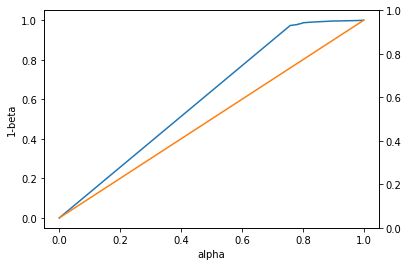

In [ ]:
plot_roc(y_test,y_pred_proba_gbbag)

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state = 0)
scores = cross_val_score(gnbag, x_data, y_data, cv = kf, scoring = 'roc_auc',n_jobs=-1)
print("Bias Error:",round(scores.mean(), 2))
print("Variance Error:",round(scores.std(ddof=1),2))

Bias Error: 0.61
Variance Error: 0.0


In [ ]:
#final model
#Naive Bayes
gnb = GaussianNB()

predictor = gnb.fit(x_data, y_data)
# y_pred_nb = predictor.predict(x_test)
# y_pred_proba_nb = predictor.predict_proba(x_test)

In [ ]:
#final model to pickle
predictorPickleName = '/content/drive/My Drive/Capstone Project/Data/pickles/nb-predictor.pkl'
dumpPickle(predictorPickleName, predictor)

#Because the one-hot encoding creates a different amount of features (columns in the dataframe),
#it is important to know which features are used in the Naive Bayes classifier as to not get into an error with different dimensions.
predictorFeaturesName = '/content/drive/My Drive/Capstone Project/Data/pickles/nb-predictor-features.pkl'
dumpPickle(predictorFeaturesName, list(df.columns))